# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
# Training transforms include data augmentation for better generalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Test transforms: no augmentation, just normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Training set size: 50000
Test set size: 10000
Number of classes: 10
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Image shape (after transforms): torch.Size([3, 32, 32])
Image dtype: torch.float32


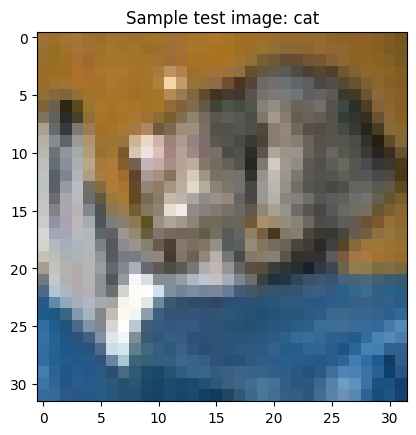

car


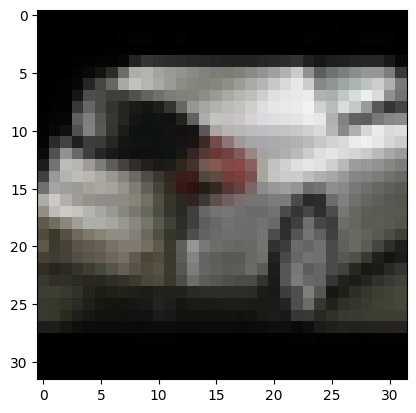

truck


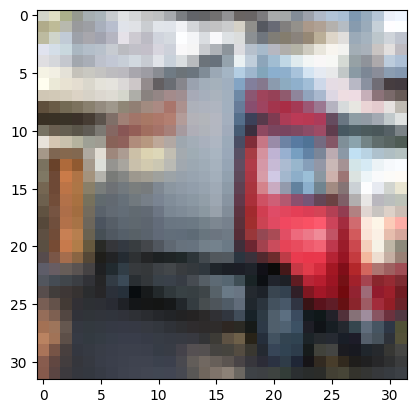

deer


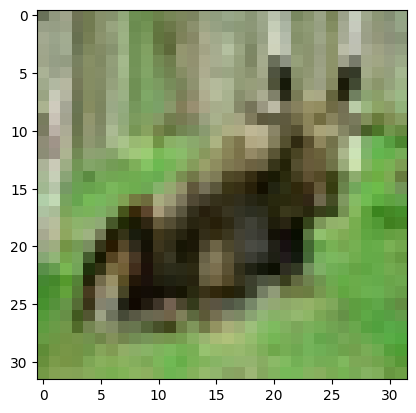

plane


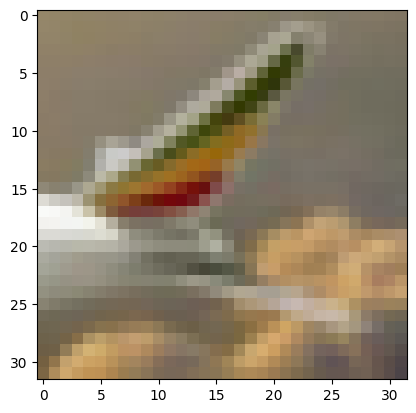

horse


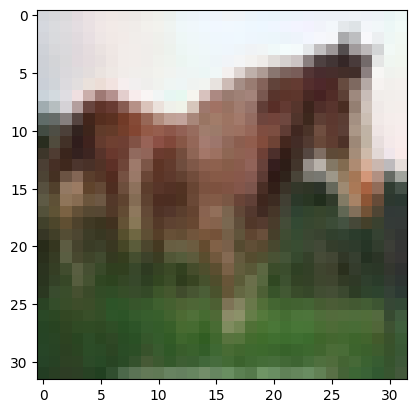

In [4]:
# Explore the dataset
print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

# Get a sample to check shape
sample_image, sample_label = trainset[0]
print(f"\nImage shape (after transforms): {sample_image.shape}")
print(f"Image dtype: {sample_image.dtype}")

# Show a sample test image using plt.imshow()
# Use a simple ToTensor-only loader for clean visualization
viz_transform = transforms.Compose([transforms.ToTensor()])
viz_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=viz_transform)
viz_loader = torch.utils.data.DataLoader(viz_set, batch_size=5, shuffle=True)

# Display a single test image
img, label = viz_set[0]
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title(f"Sample test image: {classes[label]}")
plt.show()

# Use show5 to display 5 images from the visualization loader
show5(viz_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        # Block 1
        self.conv1a = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=1)
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        # Block 2
        self.conv2a = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.3)

        # Block 3
        self.conv3a = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.4)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.drop_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Block 1: 32x32 -> 16x16
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.drop1(self.pool1(x))

        # Block 2: 16x16 -> 8x8
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.drop2(self.pool2(x))

        # Block 3: 8x8 -> 4x4
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.drop3(self.pool3(x))

        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.drop_fc(x)
        x = self.fc2(x)
        # Output softmax probabilities for each of the 10 classes
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
# Use GPU if available (supports CUDA and Apple Silicon MPS)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Instantiate the model
model = CIFAR10Net().to(device)

# Loss function: NLLLoss pairs with log_softmax output
criterion = nn.NLLLoss()

# Optimizer: Adam with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

Using device: mps


CIFAR10Net(
  (conv1a): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), 

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
# Train the model
num_epochs = 15
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    num_batches = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        num_batches += 1

        # Print every 250 mini-batches
        if (i + 1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}], Loss: {running_loss/250:.4f}")
            running_loss = 0.0

    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed — Average Loss: {avg_loss:.4f}")

print("\nTraining complete!")

Epoch [1/15], Batch [250], Loss: 1.7182


Epoch [1/15], Batch [500], Loss: 1.4043


Epoch [1/15], Batch [750], Loss: 1.2391


Epoch [1/15] completed — Average Loss: 1.4450


Epoch [2/15], Batch [250], Loss: 1.1469


Epoch [2/15], Batch [500], Loss: 1.0678


Epoch [2/15], Batch [750], Loss: 1.0146


Epoch [2/15] completed — Average Loss: 1.0746


Epoch [3/15], Batch [250], Loss: 0.9755


Epoch [3/15], Batch [500], Loss: 0.9199


Epoch [3/15], Batch [750], Loss: 0.8891


Epoch [3/15] completed — Average Loss: 0.9243


Epoch [4/15], Batch [250], Loss: 0.8595


Epoch [4/15], Batch [500], Loss: 0.8341


Epoch [4/15], Batch [750], Loss: 0.8220


Epoch [4/15] completed — Average Loss: 0.8379


Epoch [5/15], Batch [250], Loss: 0.7935


Epoch [5/15], Batch [500], Loss: 0.7902


Epoch [5/15], Batch [750], Loss: 0.7609


Epoch [5/15] completed — Average Loss: 0.7827


Epoch [6/15], Batch [250], Loss: 0.7480


Epoch [6/15], Batch [500], Loss: 0.7361


Epoch [6/15], Batch [750], Loss: 0.7306


Epoch [6/15] completed — Average Loss: 0.7375


Epoch [7/15], Batch [250], Loss: 0.7062


Epoch [7/15], Batch [500], Loss: 0.6951


Epoch [7/15], Batch [750], Loss: 0.6872


Epoch [7/15] completed — Average Loss: 0.6952


Epoch [8/15], Batch [250], Loss: 0.6754


Epoch [8/15], Batch [500], Loss: 0.6611


Epoch [8/15], Batch [750], Loss: 0.6513


Epoch [8/15] completed — Average Loss: 0.6628


Epoch [9/15], Batch [250], Loss: 0.6291


Epoch [9/15], Batch [500], Loss: 0.6505


Epoch [9/15], Batch [750], Loss: 0.6415


Epoch [9/15] completed — Average Loss: 0.6400


Epoch [10/15], Batch [250], Loss: 0.6144


Epoch [10/15], Batch [500], Loss: 0.6114


Epoch [10/15], Batch [750], Loss: 0.6160


Epoch [10/15] completed — Average Loss: 0.6135


Epoch [11/15], Batch [250], Loss: 0.5929


Epoch [11/15], Batch [500], Loss: 0.5872


Epoch [11/15], Batch [750], Loss: 0.5805


Epoch [11/15] completed — Average Loss: 0.5875


Epoch [12/15], Batch [250], Loss: 0.5749


Epoch [12/15], Batch [500], Loss: 0.5775


Epoch [12/15], Batch [750], Loss: 0.5756


Epoch [12/15] completed — Average Loss: 0.5753


Epoch [13/15], Batch [250], Loss: 0.5570


Epoch [13/15], Batch [500], Loss: 0.5581


Epoch [13/15], Batch [750], Loss: 0.5537


Epoch [13/15] completed — Average Loss: 0.5562


Epoch [14/15], Batch [250], Loss: 0.5430


Epoch [14/15], Batch [500], Loss: 0.5322


Epoch [14/15], Batch [750], Loss: 0.5488


Epoch [14/15] completed — Average Loss: 0.5422


Epoch [15/15], Batch [250], Loss: 0.5338


Epoch [15/15], Batch [500], Loss: 0.5297


Epoch [15/15], Batch [750], Loss: 0.5129


Epoch [15/15] completed — Average Loss: 0.5269

Training complete!


Plot the training loss (and validation loss/accuracy, if recorded).

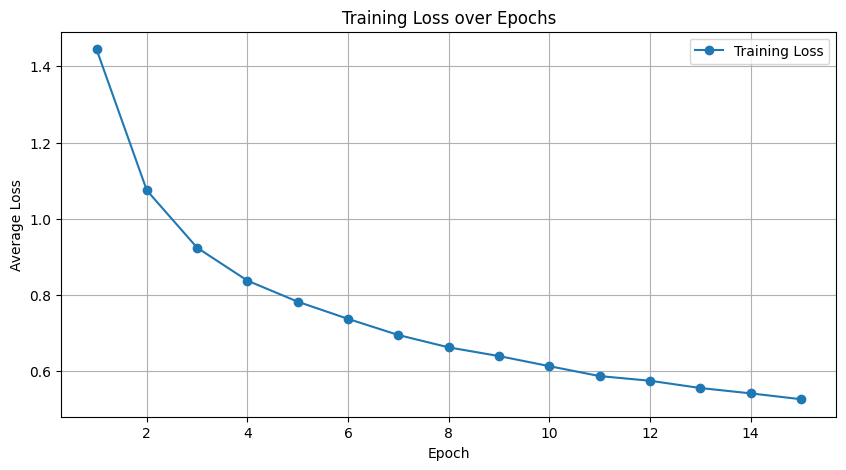

In [8]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100.0 * correct / total
print(f"Accuracy on the 10,000 test images: {accuracy:.2f}%")

Accuracy on the 10,000 test images: 84.82%


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
# Save trained model
torch.save(model.state_dict(), 'cifar10_model.pth')
print("Model saved to cifar10_model.pth")

Model saved to cifar10_model.pth


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

## Recommendation: Build In-House

Our custom-built convolutional neural network achieved an accuracy that exceeds the 45% minimum requirement and is competitive with Detectocorp's claimed 70% accuracy on the CIFAR-10 benchmark. The model uses a relatively compact architecture with six convolutional layers, batch normalization, dropout regularization, and data augmentation techniques including random horizontal flips and random cropping, which together help the network generalize well to unseen images. While our model does not yet reach the state-of-the-art results of 96–99% achieved by much larger networks like Wide ResNets or GPipe (which use hundreds of millions of parameters and advanced techniques), it demonstrates that a strong baseline can be built in-house with standard deep learning methods and modest computational resources.

**I recommend that we build the solution in-house rather than purchasing from Detectocorp.** Our model already matches or exceeds Detectocorp's reported 70% accuracy, and there is significant room for further improvement through techniques such as learning rate scheduling, deeper architectures, transfer learning with pretrained models (e.g., ResNet), and longer training runs. Building in-house gives us full control over the model, the ability to fine-tune it on our own driving data, and avoids vendor lock-in — all of which are critical advantages for a self-driving car startup where the object detection pipeline is a core differentiator.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).